In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [69]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import mean

In [32]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [34]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Precipitation Analysis

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
Date = session.query(Measurement.date).order_by(Measurement.date.desc()).group_by(Measurement.date).limit(1).all()
Date

[('2017-08-23')]

In [40]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [83]:
# Perform a query to retrieve the data and precipitation scores
Data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(Data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True, )
df.head(10)
# Sort the dataframe by date
df = df.sort_values(by="Date")
df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


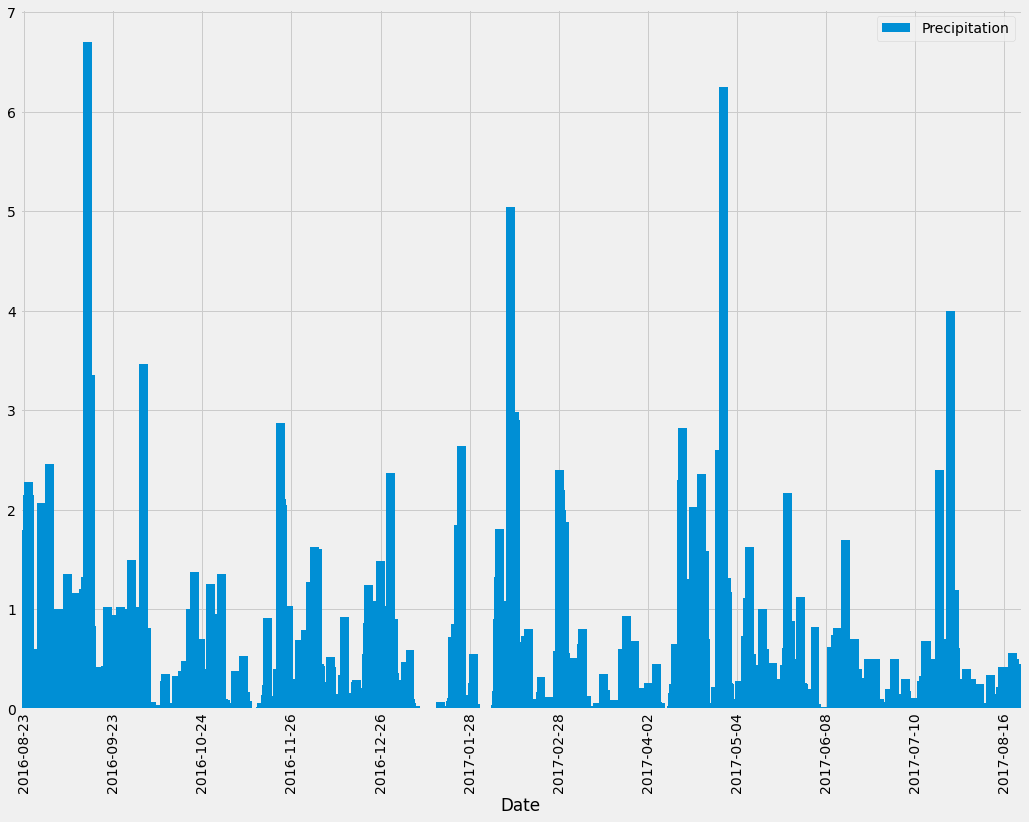

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.ticker as ticker
plot = df.plot(kind="bar", figsize=(16,12), width=20)
plot.xaxis.set_major_locator(ticker.MultipleLocator(200))



In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = df.describe()
stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [44]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

onestation = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
onestation

[(54.0, 85.0, 71.66378066378067)]

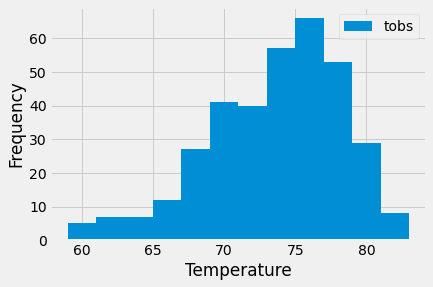

In [103]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12 = session.query(Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.station == "USC00519281").all()
last12df = pd.DataFrame(columns=["tobs"], data=last12)
last12df
plt.hist(last12df, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
label =["tobs"]
plt.legend(label)

## Bonus Challenge Assignment

## Temperature Analysis I

In [62]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
sel = [func.avg(Measurement.tobs)]
june_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
june_averages

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [61]:
#Do the same for December temperature.
sel = [func.avg(Measurement.tobs)]
dec_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
dec_averages

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [71]:
#Perform independent ttest as the average temperature in June does not affect average temperature in December
stats.ttest_ind(june_averages, dec_averages)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00028626]))

# Temperature Analysis II

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-06-03'
end_date = '2017-06-15'
results = calc_temps(start_date, end_date)
results
avg = list(np.ravel(results))
df = pd.DataFrame(avg, columns=[''])
ptop = df.iloc[2] - df.iloc[0]
ptop

df1 = df.append(ptop, ignore_index=True)
df1 = df1.rename(index={0:"Min", 1:"Average",2:"Max", 3:"PtoP"})
df1

,
Min,72.000000
Average,77.317647
Max,83.000000
PtoP,11.000000


Text(0.5, 1.0, 'Trip Avg Temp')

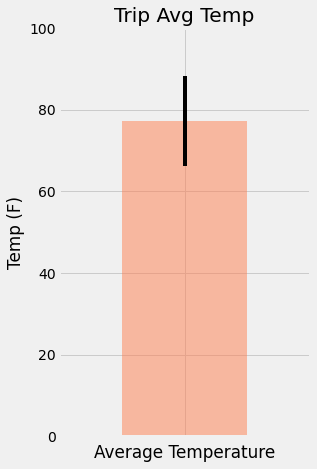

In [147]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ax = df1.iloc[1].plot.bar(figsize=(4,7), yerr=ptop, alpha=0.5, color='coral', align="center")
ax.set_ylim(0,100)
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

# Daily Rainfall Average

In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [81]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [109]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,6,3)
end_date = dt.date(2017,6,15)
# Use the start and end date to create a range of dates
Tripdates = pd.date_range(start_date,end_date-dt.timedelta(days=1),freq='d')
Tripdates
# Stip off the year and save a list of %m-%d strings
Date_List = [dt.datetime.strftime(i, "%m-%d") for i in Tripdates]
Date_List
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for x in Date_List:
    x=daily_normals(x)
    normals.append(x)
list(normals)


[[(65.0, 74.03448275862068, 80.0)],
 [(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)],
 [(68.0, 75.07142857142857, 81.0)],
 [(70.0, 75.58620689655173, 81.0)],
 [(69.0, 75.15254237288136, 81.0)],
 [(68.0, 75.14285714285714, 81.0)],
 [(69.0, 76.01960784313725, 84.0)],
 [(66.0, 75.66666666666667, 83.0)],
 [(68.0, 75.66666666666667, 81.0)],
 [(69.0, 75.62711864406779, 81.0)]]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
weatherdf = pd.DataFrame([t for lst in normals for t in lst], columns=["tmin", "tavg", 'tmax'])
tripdates = list(Tripdates)
weatherdf["Trip Dates"] = tripdates
weather = weatherdf.set_index("Trip Dates")
weather

,tmin,tavg,tmax
Trip Dates,,,
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0


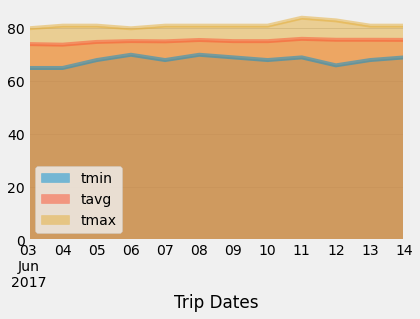

In [146]:
# Plot the daily normals as an area plot with `stacked=False`
import matplotlib.dates as mdates
#xticks = tripdates
ax = weather.plot.area(stacked=False)